In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
print(X.shape)

# scaler = StandardScaler().fit(X)
# X_scaled = scaler.transform(X)
# Normalizer_ = Normalizer().fit(X)
# X_norm = Normalizer_.transform(X)
# PCA_ = PCA(n_components=60).fit(X_norm)
# X_PCA = PCA_.transform(X_norm)
# # X_TSNE = TSNE(n_components=60, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
# reducer = umap.UMAP(min_dist=0.9, n_components=60)
# X_UMAP = reducer.fit_transform(X_norm)
# X_batch = np.reshape(X_UMAP, (X_UMAP.shape[0]//5,5,X_UMAP.shape[1]))
# # X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)

(53275, 5184)


In [4]:
filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


## Traditional Clustering

In [10]:
# Batch methods
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import matplotlib.cm as cm
import math

# Single methods
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def tagger(samples, n_clusters):
    labels = []
    for cluster in range(n_clusters):
        index = np.where(Kmeans.labels_ == cluster)
        index = list(index[0])
        labels.append(samples[index])
    df_ae["cluster"] = Kmeans.labels_ 
    return labels

def joyplot(n_clusters, joy_vars = ["hour", "location"]):
    size_x = 8
    size_y = 6
    labels_cluster = []
    for cluster in range(n_clusters):
        print(f"cluster: {cluster}")
        df = pd.DataFrame()
        for i, label in enumerate(joy_vars):
            labels_cluster.append(tagger(np.asarray(df_ae[label]), n_clusters))
            df[label] = labels_cluster[i][cluster]

        if (label == "location"):
            joypy.joyplot(df, by="location", column="hour", range_style='own',
                          grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x, size_y),
                          title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                          colormap=cm.autumn_r, fade=False)
            
        elif (label == "cover"):
            joypy.joyplot(df, by="cover", column="location", range_style='own',
                          grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x, size_y),
                          title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                          colormap=cm.autumn_r, fade=False)

        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.show()

    return labels_cluster

def one_cluster_eval(cluster, label):
        index = np.where(Kmeans.labels_ == cluster)
        index = list(index[0])
        labels_cluster = df_ae.loc[index, label]
#         labels_cluster = labels_cluster.loc[:,label]
        return list(labels_cluster)

In [76]:
def num_rows_cols(num_elements):
    num_rows = int(np.sqrt(num_elements))
    num_cols = (num_elements + num_rows - 1) // num_rows
    return num_rows, num_cols

def get_row_col(pos, cols):
    row = pos // cols
    col = pos % cols
    return row, col

class ClusteringResults:
    def __init__(self, model, df, y_label="hour", hist_library="plt"):
        self._labels_cluster = None
        self._n_labels = None
        self._label = y_label
        self._model = model
        self._n_clusters = len(set(model.labels_))
        self._y = df
        self._n_labels = set(list(self._y.loc[:,self._label]))
        
    def one_cluster_eval(self, cluster):
        index = np.where(self._model.labels_ == cluster)
        index = list(index[0])
        self._labels_cluster = self._y.loc[index, self._label]
        return list(self._labels_cluster)

    def tagger(self, samples):
        labels = []
        self._y["cluster"] = self._model.labels_
        for cluster in range(self._n_clusters):
            index = np.where(self._model.labels_ == cluster)
            index = index[0]
            labels.append(samples[index])
        return labels

    def joyplot(self, joy_vars=None):
        if joy_vars is None:
            joy_vars = ["hour", "location"]
        size_x = 8
        size_y = 6
        labels_cluster = []
        df = pd.DataFrame()
        for cluster in range(self._n_clusters):
            df = pd.DataFrame()
            for i, label in enumerate(joy_vars):
                labels_cluster.append(self.tagger(np.asarray(self._y[label])))
                df[label] = labels_cluster[i][cluster]

            if (self._label == "location"):
                joypy.joyplot(df, by="location", column="hour", range_style='own',
                              grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x, size_y),
                              title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                              colormap=cm.autumn_r, fade=False)
            plt.xticks(fontsize=22)
            plt.yticks(fontsize=22)
            plt.show()

    def histograms(self, hist_library="plt", root=None, save=True):
        bins = list(self._n_labels)
        num_rows, num_cols = num_rows_cols(self._n_clusters)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))
        if self._n_clusters <= 3:
            axes = np.expand_dims(axes, 0)
            fig.set_figheight(6)
            fig.set_figwidth(12)
            if self._n_clusters == 1:
                axes = np.expand_dims(axes, 0)
            else:
                pass
        else:
            pass
        for hist in range(self._n_clusters):
            aux = self.one_cluster_eval(hist)
            ax_0, ax_1 = get_row_col(hist, num_cols)
            if hist_library == "plt":
                axes[ax_0][ax_1].hist(aux, histtype="bar",
                                      color="paleturquoise", cumulative=False,
                                      edgecolor='black',
                                      linewidth=1.2, bins=bins, stacked=False)
                axes[ax_0][ax_1].set_title(f"Cluster: {hist+1}", size=16)
            elif hist_library == "sns":
                sns.distplot(aux, bins=np.arange(aux.min(), aux.max() + 1),
                             hist_kws=dict(edgecolor="black", linewidth=1),
                             ax=axes[ax_0, ax_1])
                axes[ax_0][ax_1].set_title(f"Cluster: {hist+1}", size=16)
            else:
                raise Exception(f"Library {self._hist_library} unused")

            if (root is not None) & (save is True):
                plt.savefig(f"{root}/Histograms_plot_{self._n_clusters}.pdf", format="pdf")
            else:
                pass
        plt.show()


In [80]:
Kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
Kmeans_Results = ClusteringResults(Kmeans, df_ae, y_label="hour")


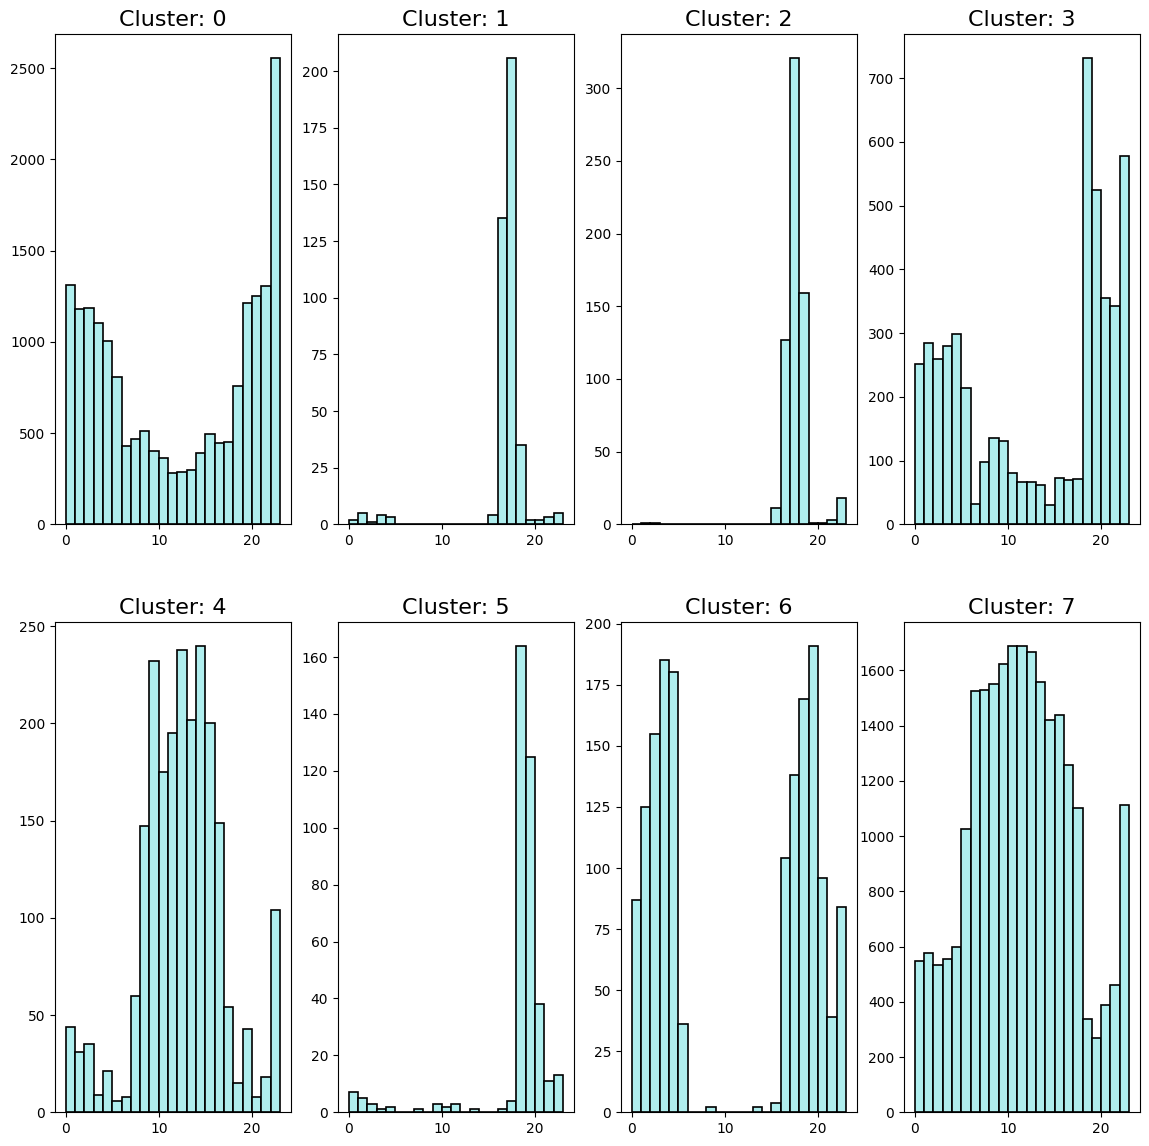

In [81]:
Kmeans_Results.histograms()

In [ ]:
f = Kmeans_Results.tagger(path_flat)
torch.save(f,f"temporal/clusters/kmeans_UMAP_clustering_labels_PosAE_rainless_{len(set(Kmeans.labels_))}")
leido= torch.load(f"Features/clustering_labels_clusters_3")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
Kmeans_Results.histograms()

## Kmeans

In [ ]:
clusters = [3, 5, 7, 10, 15, 20, 25, 30, 35]

In [ ]:
silhouette_score_Kmeans = []
CH_score_Kmeans = []
DB_score_Kmeans = []

# mean = X.mean()
# std = X.std()
for id_, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_norm)
    silhouette_score_Kmeans.append(metrics.silhouette_score(X_norm, Kmeans.labels_))
    DB_score_Kmeans.append(DB(X_norm, Kmeans.labels_))
    CH_score_Kmeans.append(CH(X_norm, Kmeans.labels_))
    print(f"Silhouette: {silhouette_score_Kmeans}, DB: {DB_score_Kmeans}, CH: {CH_score_Kmeans}")
    plot_silhouette(X_norm, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id_], method=f"Kmeans", save=True)
    cluster_centers = Normalizer_.inverse_transform(Kmeans.cluster_centers_)
    plot_centroids(cluster_centers, testing, method="Kmeans", save=False)
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms(root="temporal/clustering_results/Kmeans/")#, root="temporal/clustering_results/Kmeans/")
    Kmeans_Results.joyplot()
with open(f"temporal/clustering_results/Kmeans/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(silhouette_score_Kmeans, file)
with open(f"temporal/clustering_results/Kmeans/DB_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(DB_score_Kmeans, file)
with open(f"temporal/clustering_results/Kmeans/CH_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(CH_score_Kmeans, file)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

# Data frame de muestra
df2 = pd.DataFrame({'var1': np.random.normal(70, 100, 500),
                   'var2': np.random.normal(250, 100, 500),
                   'grupo': random.choices(["G1", "G2", "G3", "G4", "G5"], k = 500)})

fig, ax = joypy.joyplot(df2, by = "grupo", column = "var1")

# plt.show()